#### <a>Objective: To predict Credit Card Spend & Credit Limit using identified Key Drivers.</a>

#### <a>Business Problem:</a>

One of the global banks would like to understand what factors driving credit card spend are. The bank want use these insights to calculate credit limit. In order to solve the problem, the bank conducted survey of 5000 customers and collected data.

The objective of this case study is to understand what’s driving the total spend. Given the factors, predict credit limit for the new applicants.

#### <a>Importing Modules

In [1]:
import numpy as np
import pandas as pd

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_regression, RFE, VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn import metrics

from scipy import stats
import pylab

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Writing output data into excel
output = pd.ExcelWriter('CreditCard_output.xlsx')

#### <a>Creating UDFs

In [3]:
# Create Statistical Summary for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), len(x.value_counts()), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.50),
                      x.quantile(0.99),x.max()], 
                      index = ['Count', 'Unique', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN',
                               'P1', 'P50', 'P99' ,'MAX'])

In [4]:
# Create Statistical Summary for categorical variables
def categorical_var_summary(a):
    Mode = a.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([a.count(), a.isnull().sum(), len(a.value_counts()), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                      round(((Mode.iloc[0, 1] * 100)/a.count()), 2)], 
                      index = ['COUNT', 'MISS', 'UNIQUE', 'MODE', 'FREQ', 'PERCENT'])

In [5]:
#Outlier treatment function
def outlier_capping(x):
    x = x.clip(lower = x.quantile(0.01),upper = x.quantile(0.99))
    return x

In [6]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

In [7]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

#### <a>Loading Dataset

In [8]:
ds = pd.read_excel('Data Set.xlsx')

#### <a>Understanding the data

In [9]:
#Dataset View
ds.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


In [10]:
#Dataset Information
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


In [11]:
#Column names
print(list(ds.columns))

['custid', 'region', 'townsize', 'gender', 'age', 'agecat', 'birthmonth', 'ed', 'edcat', 'jobcat', 'union', 'employ', 'empcat', 'retire', 'income', 'lninc', 'inccat', 'debtinc', 'creddebt', 'lncreddebt', 'othdebt', 'lnothdebt', 'default', 'jobsat', 'marital', 'spoused', 'spousedcat', 'reside', 'pets', 'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small', 'pets_saltfish', 'pets_freshfish', 'homeown', 'hometype', 'address', 'addresscat', 'cars', 'carown', 'cartype', 'carvalue', 'carcatvalue', 'carbought', 'carbuy', 'commute', 'commutecat', 'commutetime', 'commutecar', 'commutemotorcycle', 'commutecarpool', 'commutebus', 'commuterail', 'commutepublic', 'commutebike', 'commutewalk', 'commutenonmotor', 'telecommute', 'reason', 'polview', 'polparty', 'polcontrib', 'vote', 'card', 'cardtype', 'cardbenefit', 'cardfee', 'cardtenure', 'cardtenurecat', 'card2', 'card2type', 'card2benefit', 'card2fee', 'card2tenure', 'card2tenurecat', 'cardspent', 'card2spent', 'active', 'bfast', 

#### <a>Getting Target variable - y

In [12]:
# Target variable (y) - Total Spent = Primary Card + Secondary Card
ds['total_spent'] = ds['cardspent'] + ds['card2spent']

#Droping cardspent and card2spent columns as it is directly related to y - total_spent
ds.drop(labels = ['cardspent', 'card2spent'], axis = 1, inplace = True)

<AxesSubplot:xlabel='total_spent', ylabel='Density'>

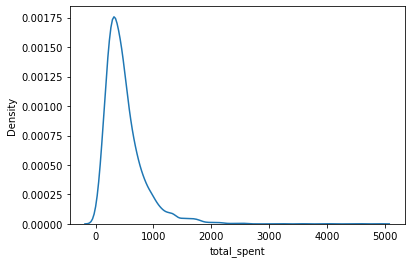

In [13]:
#Distribution of dependent variable - total_spent
sns.kdeplot(ds.total_spent)

In [14]:
#Dependent Variable is right skewed
ds.total_spent.skew()

2.707546987697521

<AxesSubplot:xlabel='log_ts', ylabel='Density'>

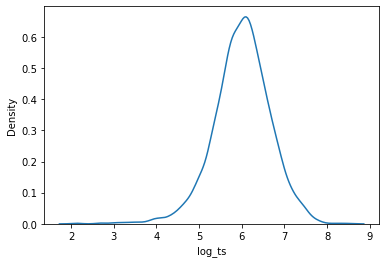

In [15]:
#Making the distribution normal by log transformation
ds['log_ts'] = np.log(ds.total_spent)

#Distribution after log transformation
sns.kdeplot(ds.log_ts)

In [16]:
#New dependent variable - log_ts is left skewed which is less than original
ds.log_ts.skew()

-0.539836787814146

#### <a>Checking Linearity of Data

<AxesSubplot:xlabel='income', ylabel='total_spent'>

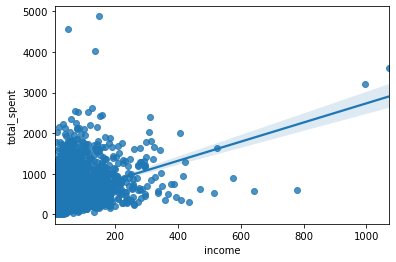

In [17]:
sns.regplot(x = 'income', y = 'total_spent', data = ds)

<AxesSubplot:xlabel='income', ylabel='log_ts'>

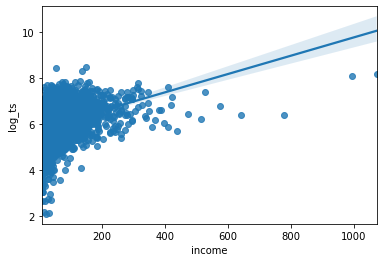

In [18]:
sns.regplot(x = 'income', y = 'log_ts', data = ds)

Most of the data points lies near the line showing normal distribution. We can proceed with log transformed total spent variable 'log_ts'. 

#### <a>Profile Report

In [19]:
#pandas_profiling.ProfileReport(ds)

#### <a>Getting Categorical and Continuous Variables

In [20]:
#Defining incomedebtratio and incomedebtratio_cat variables

In [21]:
#Identifying Categorical Variables
cat_cols = ['region','townsize','gender','agecat','edcat','birthmonth','jobcat','union','empcat','retire',
          'inccat','default','jobsat','marital','spousedcat','homeown','hometype','addresscat','carown',
          'cartype','carcatvalue','carbought','carbuy','commute','commutecat','commutecar',
          'commutemotorcycle','commutecarpool','commutebus','commuterail','commutepublic','commutebike','commutewalk',
         'commutenonmotor','telecommute','reason','polview','polparty','polcontrib','vote','card','cardtype','cardbenefit',
         'cardfee','cardtenurecat','card2','card2type','card2benefit','card2fee','card2tenurecat',
         'active','bfast','churn','tollfree','equip','callcard','wireless','multline','voice','pager','internet','callid',
         'callwait','forward','confer','ebill','owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax',
        'news','response_01','response_02','response_03']

#Typecasting Categorical Variables to object
ds[cat_cols] = ds[cat_cols].astype('object')

In [22]:
#Getting Continuous Variables
cont_cols = ds.select_dtypes(['int64','float64']).columns

In [23]:
#Removing categorical variables having numerical variables
ds.drop(labels = ['agecat', 'edcat', 'empcat', 'inccat', 'spousedcat', 'addresscat', 'carcatvalue', 'cardtenurecat', 'card2tenurecat'], axis = 1, inplace = True)

In [24]:
cat_cols = ds.select_dtypes('object').columns

In [25]:
#Category Columns
ds[cat_cols].columns

Index(['custid', 'region', 'townsize', 'gender', 'birthmonth', 'jobcat',
       'union', 'retire', 'default', 'jobsat', 'marital', 'homeown',
       'hometype', 'carown', 'cartype', 'carbought', 'carbuy', 'commute',
       'commutecat', 'commutecar', 'commutemotorcycle', 'commutecarpool',
       'commutebus', 'commuterail', 'commutepublic', 'commutebike',
       'commutewalk', 'commutenonmotor', 'telecommute', 'reason', 'polview',
       'polparty', 'polcontrib', 'vote', 'card', 'cardtype', 'cardbenefit',
       'cardfee', 'card2', 'card2type', 'card2benefit', 'card2fee', 'active',
       'bfast', 'churn', 'tollfree', 'equip', 'callcard', 'wireless',
       'multline', 'voice', 'pager', 'internet', 'callid', 'callwait',
       'forward', 'confer', 'ebill', 'owntv', 'ownvcr', 'owndvd', 'owncd',
       'ownpda', 'ownpc', 'ownipod', 'owngame', 'ownfax', 'news',
       'response_01', 'response_02', 'response_03'],
      dtype='object')

In [26]:
#Continuous columns
ds[cont_cols].columns

Index(['age', 'ed', 'employ', 'income', 'lninc', 'debtinc', 'creddebt',
       'lncreddebt', 'othdebt', 'lnothdebt', 'spoused', 'reside', 'pets',
       'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small',
       'pets_saltfish', 'pets_freshfish', 'address', 'cars', 'carvalue',
       'commutetime', 'cardtenure', 'card2tenure', 'tenure', 'longmon',
       'lnlongmon', 'longten', 'lnlongten', 'tollmon', 'lntollmon', 'tollten',
       'lntollten', 'equipmon', 'lnequipmon', 'equipten', 'lnequipten',
       'cardmon', 'lncardmon', 'cardten', 'lncardten', 'wiremon', 'lnwiremon',
       'wireten', 'lnwireten', 'hourstv', 'total_spent', 'log_ts'],
      dtype='object')

In [27]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 121 entries, custid to log_ts
dtypes: float64(30), int64(20), object(71)
memory usage: 4.6+ MB


#### <a>Exploratory Data Analysis

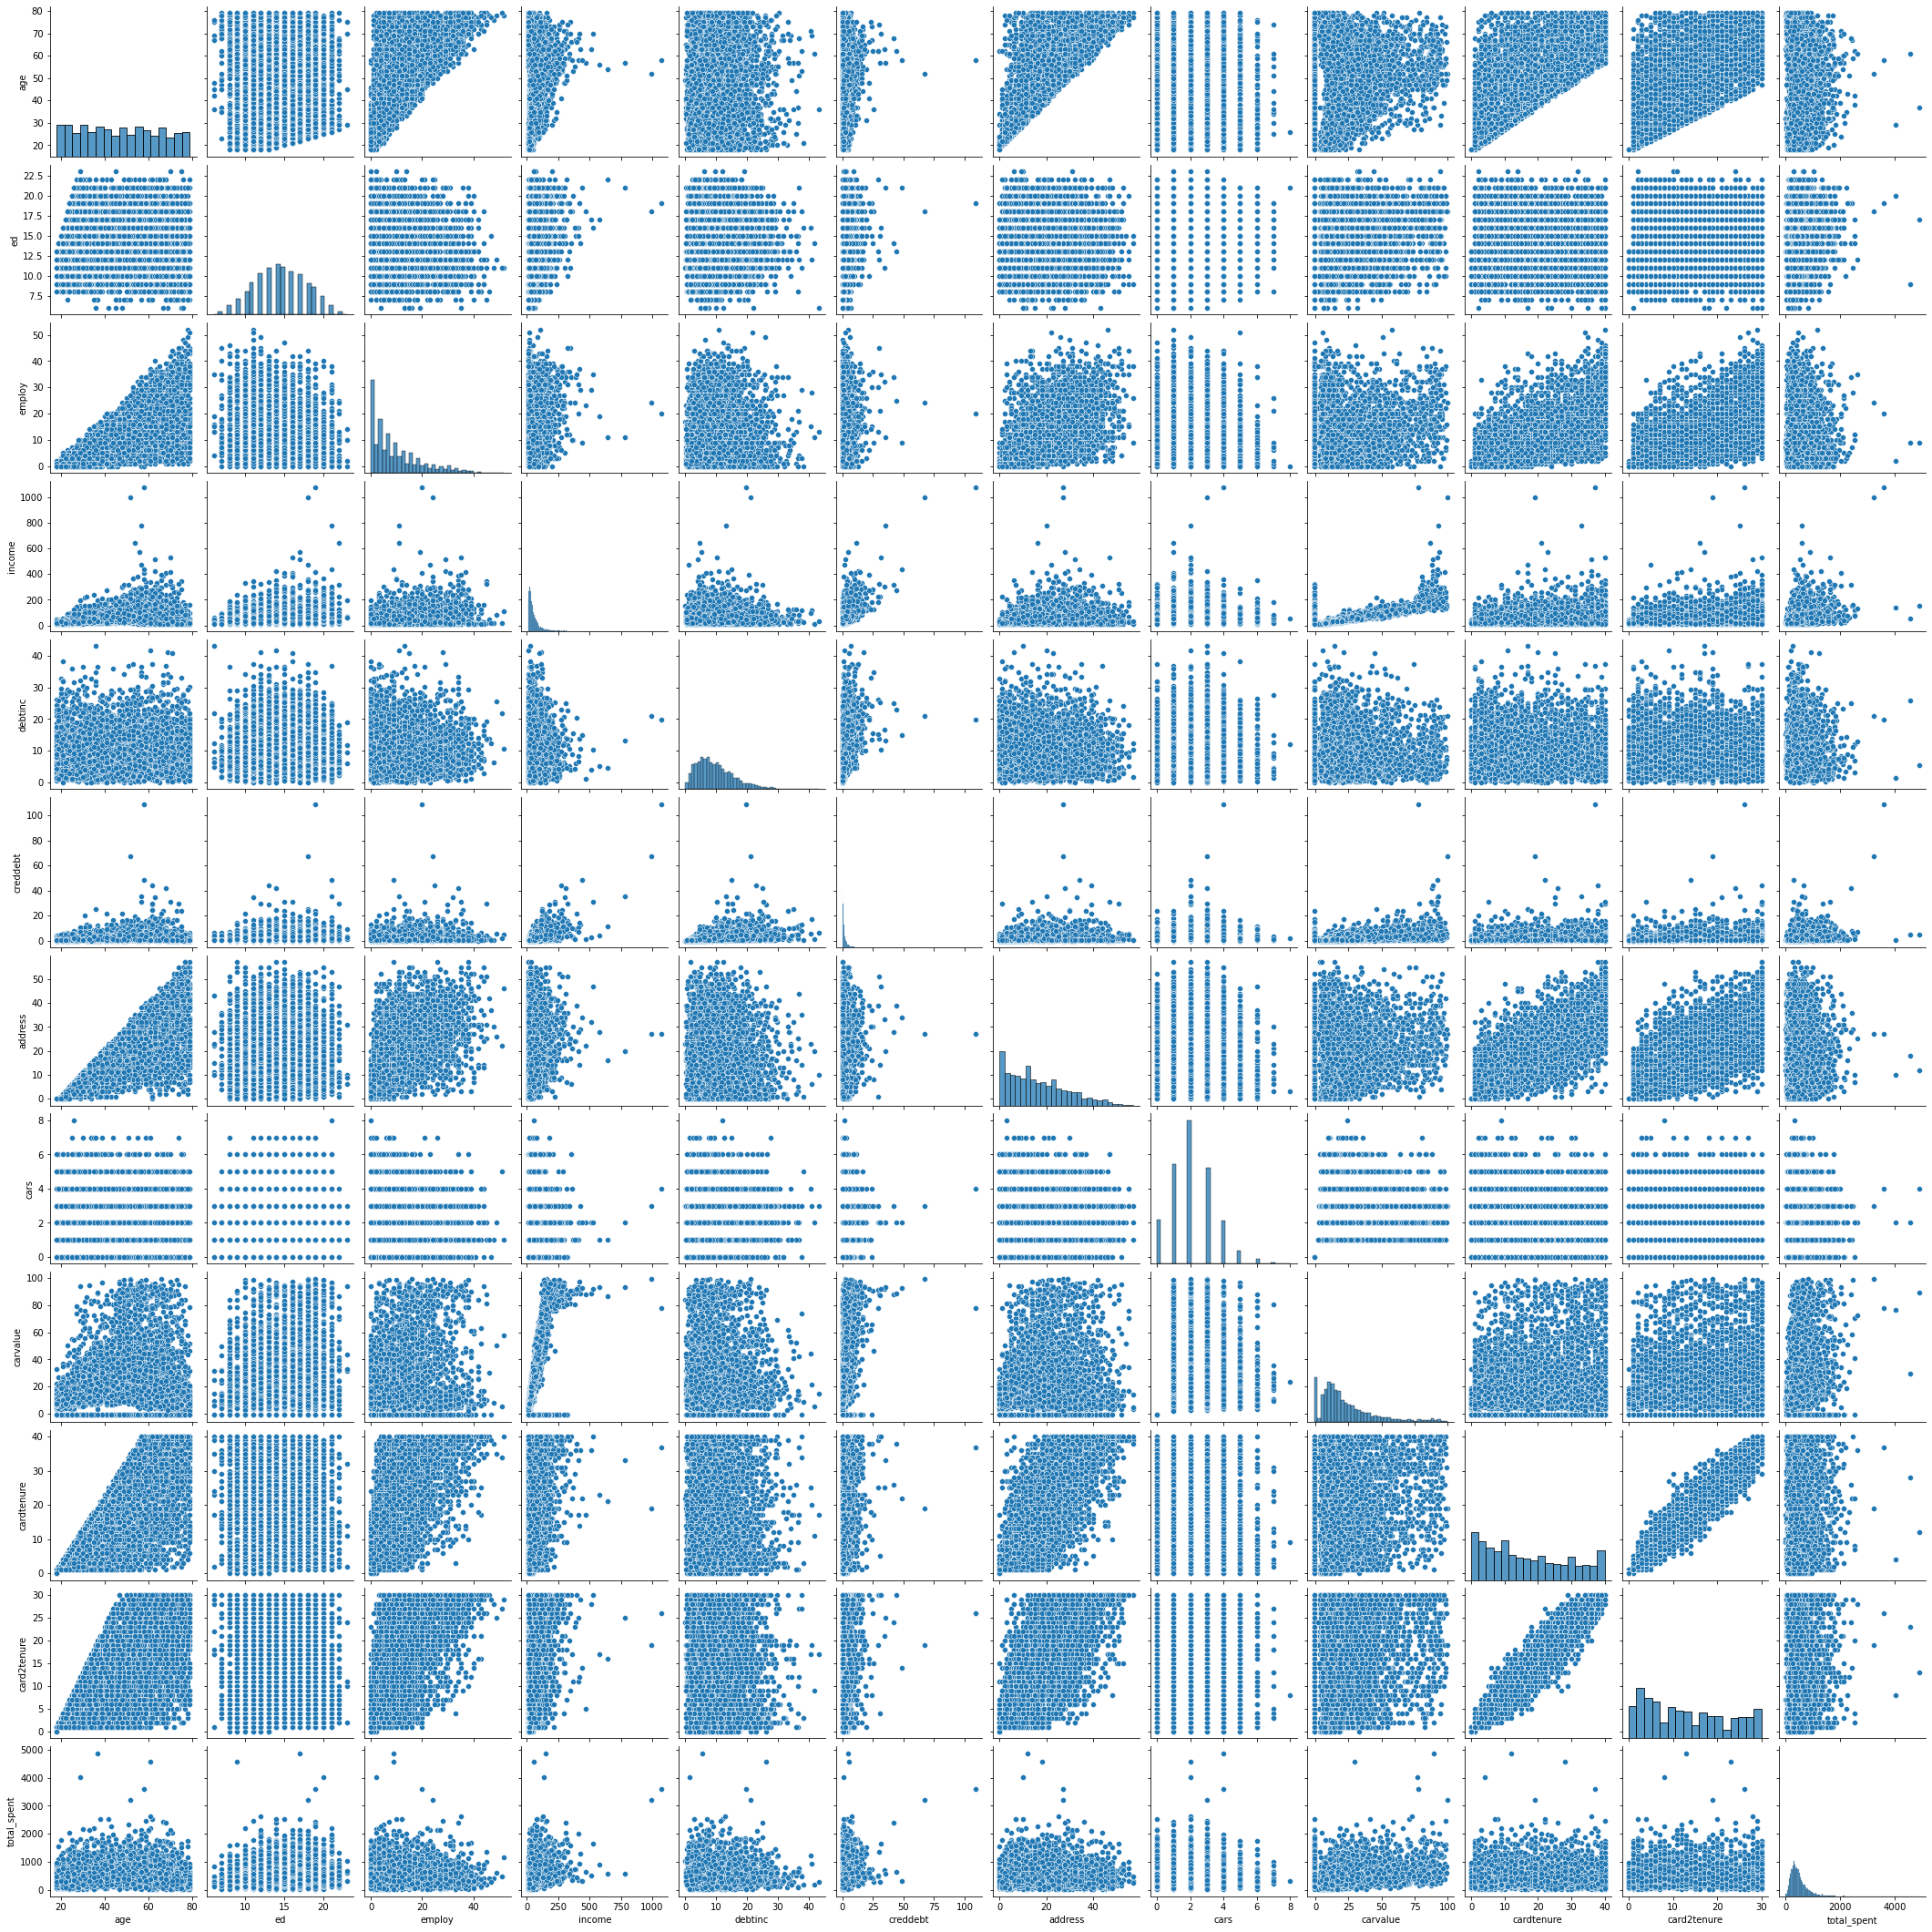

In [28]:
#Visualizing pairwise correlation of some continuous variables
sns.pairplot(ds[['age','ed','employ','income','debtinc','creddebt','address','cars','carvalue',
                 'cardtenure','card2tenure','total_spent']])
plt.show()

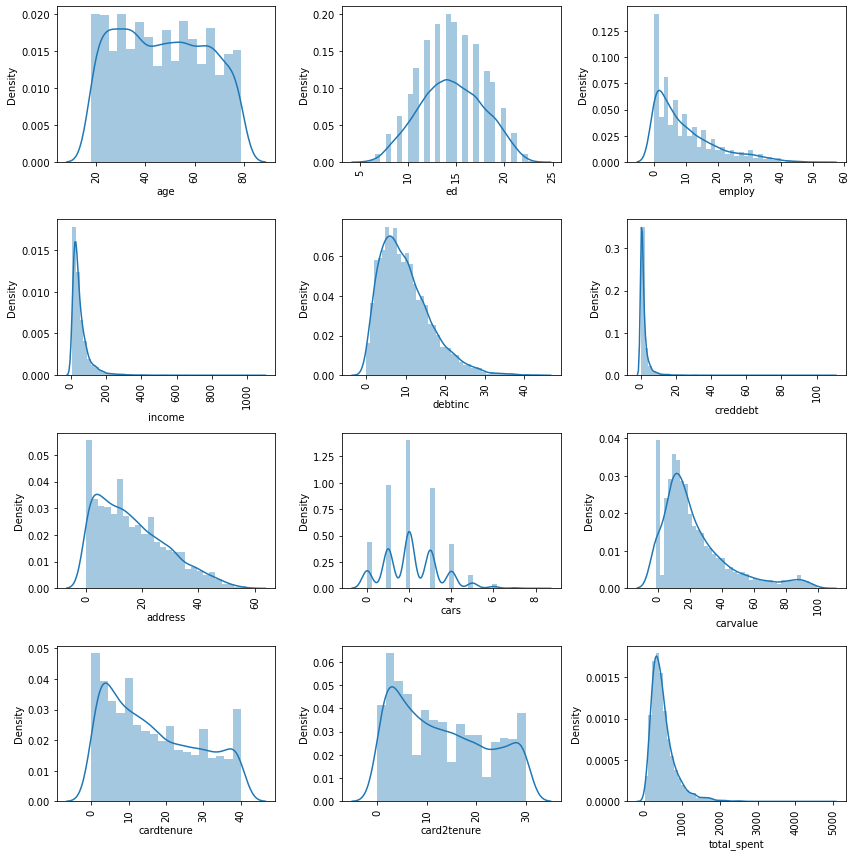

In [29]:
#Distribution plot for some continuous variables
plt_cont_cols = ['age','ed','employ','income','debtinc','creddebt','address','cars','carvalue',
                 'cardtenure','card2tenure','total_spent']
plt.figure(figsize = (12,12))
for i, col in enumerate(plt_cont_cols):
    plt.subplot(4, 3, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.distplot(a = ds[col])
    plt.xticks(rotation = 90)
    plt.tight_layout()

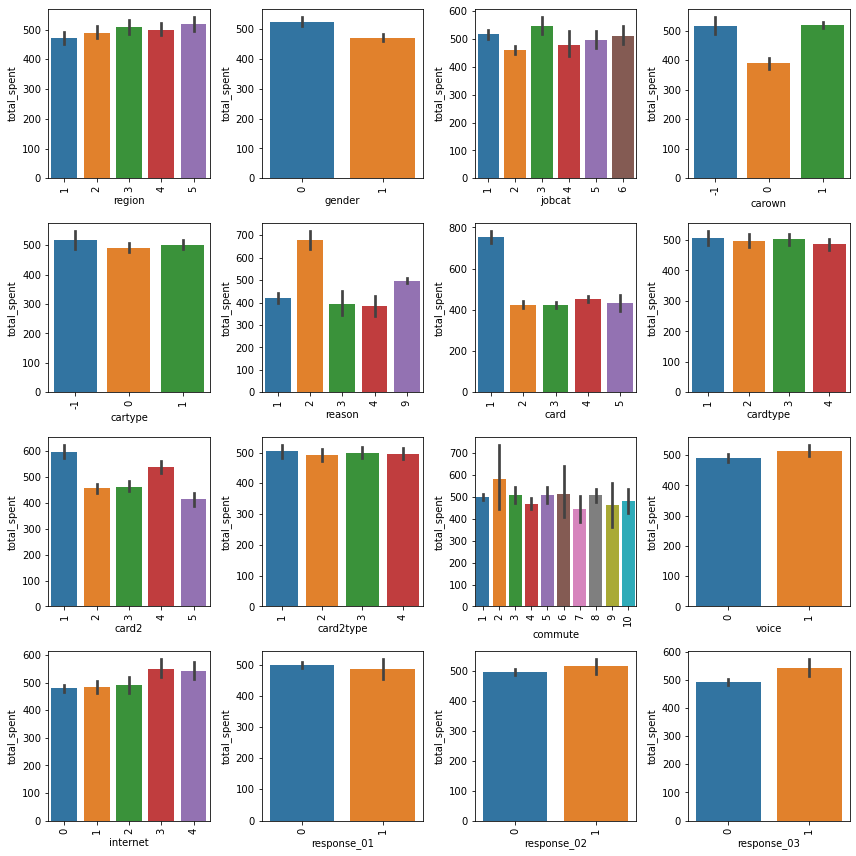

In [30]:
#Total price across some categorical variables
plt_cat_cols = ['region','gender','jobcat','carown','cartype','reason','card','cardtype',
                'card2','card2type','commute','voice','internet','response_01','response_02',
                'response_03']
plt.figure(figsize = (12,12))
for i, col in enumerate(plt_cat_cols):
    plt.subplot(4, 4, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.barplot(x = ds[col], y = ds.total_spent)
    plt.xticks(rotation = 90)
    plt.tight_layout()

Observations:

- Total Spent for region 3 & 5 is high
- Male spent is higher than female
- Job category is also impacts the total_spent
- Total spent is less for those who don't own a car
- People who bought the card for convenience have high total spent
- American Express card total spent is higher than others for both card1 and card2
- Total spent for people who commutes by Motorcycle is high
- People with voice mail service have high total spent
- Total spent is high for those who uses 'cable modem' and 'other' type of internet services
- Response to product offer 3 is higher

#### <a>Getting Statistical Summary of the data

In [31]:
#Summary for continuous variables
cont_summary = ds[cont_cols].apply(continuous_var_summary).round(2)
cont_summary.to_excel(output, 'Continuous Variable Summary', index = True)
cont_summary

,age,ed,employ,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,...,lncardmon,cardten,lncardten,wiremon,lnwiremon,wireten,lnwireten,hourstv,total_spent,log_ts
Count,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,4999.00,5000.00,4999.00,...,3581.00,4998.00,3578.00,5000.00,1344.00,5000.00,1344.00,5000.00,5000.00,5000.00
Unique,62.00,18.00,52.00,266.00,266.00,325.00,4950.00,4941.00,4973.00,4972.00,...,270.00,697.00,696.00,746.00,745.00,1328.00,1327.00,32.00,4886.00,4860.00
NMISS,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,...,1419.00,2.00,1422.00,0.00,3656.00,0.00,3656.00,0.00,0.00,0.00
SUM,235128.00,72715.00,48652.00,273798.00,18499.55,49770.80,9286.63,-652.14,18272.30,3483.88,...,10419.75,3600951.00,22993.33,53505.95,4845.12,2109923.05,9150.13,98225.00,2490393.15,30006.22
MEAN,47.03,14.54,9.73,54.76,3.70,9.95,1.86,-0.13,3.65,0.70,...,2.91,720.48,6.43,10.70,3.61,421.98,6.81,19.64,498.08,6.00
MEDIAN,47.00,14.00,7.00,38.00,3.64,8.80,0.93,-0.08,2.10,0.74,...,2.90,425.00,6.64,0.00,3.60,0.00,7.15,20.00,414.25,6.03
STD,17.77,3.28,9.69,55.38,0.75,6.40,3.42,1.27,5.40,1.13,...,0.56,922.23,1.17,19.80,0.39,1001.00,1.28,5.17,351.53,0.67
VAR,315.78,10.77,93.91,3066.67,0.56,40.96,11.67,1.62,29.11,1.27,...,0.32,850499.92,1.37,392.03,0.15,1002007.58,1.65,26.68,123572.83,0.45
MIN,18.00,6.00,0.00,9.00,2.20,0.00,0.00,-6.60,0.00,-4.09,...,1.18,0.00,1.56,0.00,2.54,0.00,2.54,0.00,8.11,2.09
P1,18.00,8.00,0.00,9.00,2.20,0.70,0.03,-3.40,0.11,-2.17,...,1.66,0.00,2.48,0.00,2.81,0.00,3.04,0.00,58.20,4.06


In [32]:
#Summary for categorical variables
cat_summary = ds[cat_cols].apply(categorical_var_summary).round(2)
cat_summary.to_excel(output, 'Categorical Variable Summary', index = True)
cat_summary

,custid,region,townsize,gender,birthmonth,jobcat,union,retire,default,jobsat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
COUNT,5000,5000.00,4998.00,5000.00,5000,5000.0,5000.00,5000.00,5000.00,5000.0,...,5000.00,5000.0,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00
MISS,0,0.00,2.00,0.00,0,0.0,0.00,0.00,0.00,0.0,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
UNIQUE,5000,5.00,5.00,2.00,12,6.0,2.00,2.00,2.00,5.0,...,2.00,2.0,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
MODE,5453-WEWTVZ-OZ6,5.00,1.00,1.00,September,2.0,0.00,0.00,0.00,3.0,...,1.00,0.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
FREQ,1,1027.00,1436.00,2518.00,458,1640.0,4244.00,4262.00,3829.00,1085.0,...,4664.00,3995.0,3164.00,2604.00,2626.00,4106.00,2637.00,4582.00,4351.00,4487.00
PERCENT,0.02,20.54,28.73,50.36,9.16,32.8,84.88,85.24,76.58,21.7,...,93.28,79.9,63.28,52.08,52.52,82.12,52.74,91.64,87.02,89.74


From Statistical Summary of the data, we can see that there are outliers and missing values in the data.

#### <a>Data Preparation

In [33]:
#Handling Outliers
ds[cont_cols] = ds[cont_cols].apply(outlier_capping)
ds[cont_cols].to_excel(output, 'Outlier Treatment', index = True)

In [34]:
#Columns having more than 1000 missing values
mv = ds.isna().sum()
mv[mv>1000]

lntollmon     2622
lntollten     2622
lnequipmon    3296
lnequipten    3296
lncardmon     1419
lncardten     1422
lnwiremon     3656
lnwireten     3656
dtype: int64

In [35]:
#Dropping columns having more than 1000 missing values
ds.drop(['lntollmon', 'lntollten', 'lnequipmon', 'lnequipten', 'lncardmon',
       'lncardten', 'lnwiremon', 'lnwireten'], axis = 1, inplace = True)

In [36]:
#Dropping custid as it is unique and birthmonth as it is not significant for model
ds.drop(['custid', 'birthmonth'], axis = 1, inplace = True)

In [37]:
#Final list of continuous and categorical columns
cont_cols = ds.select_dtypes(['int64', 'float64']).columns
cat_cols = ds.select_dtypes(['object']).columns

In [38]:
#Handling Missing values
#For continuous using mean to fill missing values
ds[cont_cols] = ds[cont_cols].apply(missing_imputation)
#For categorical using mode to fill missing values
ds[cat_cols] = ds[cat_cols].apply(missing_imputation)

In [39]:
#Checking for missing values
ds.isna().sum().values.sum()

0

In [40]:
#Getting incomedebtratio and incdebtratio_cat to define credit limit 
ds['incomedebtratio'] = ds['income']/ds['debtinc']

ds['incdebtratio_cat'] = np.where(ds['incomedebtratio']<=10, 1,
                         np.where((ds['incomedebtratio']>10) & (ds['incomedebtratio']<=20),2,
                         np.where((ds['incomedebtratio']>20) & (ds['incomedebtratio']<=30),3,
                         np.where((ds['incomedebtratio']>30) & (ds['incomedebtratio']<=40),4,
                         np.where((ds['incomedebtratio']>40) & (ds['incomedebtratio']<=50),5,6)))))

In [41]:
ds.to_excel(output, 'Missing Treatment', index = True)

#### <a>Correlation Matrix

In [42]:
corr_target = ds.corrwith(ds['log_ts']).sort_values(ascending = False)
corr_target.to_excel(output, 'Correlation with Target', index = True)

<AxesSubplot:>

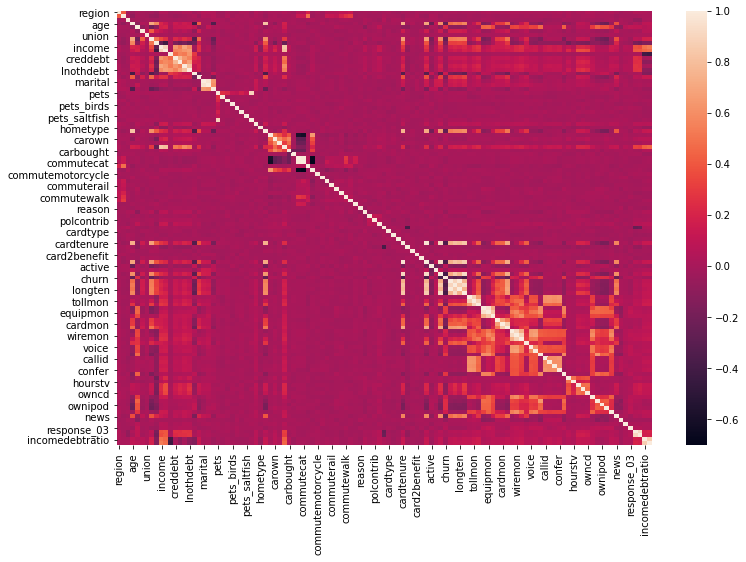

In [43]:
cm = ds.corr()
plt.figure(figsize = (12,8))
sns.heatmap(cm)

In [44]:
cm.to_excel(output, 'Correlation Matrix', index = True)

In [45]:
#Creating Dummy Variables for categorical variables
for col in cat_cols:
    ds = create_dummies(ds, col)  

In [46]:
ds.to_excel(output, 'Dummy Creation', index = True)

#### <a>Feature Selection based on Importance using F - Regression

In [47]:
#Getting features and target
feat_cols = ds.columns.difference(['total_spent','log_ts'])
target = ds.log_ts

#Performing f-test for each x variable with y
f_values, p_values = f_regression(ds[feat_cols], target)

#Storing data as a DataFrame
fr_df = pd.DataFrame({'Features':feat_cols, 'F_values':f_values, 'p_values':p_values.round(3)})

#Getting significant variables at 90% : p = 0.1
fr_df = fr_df.loc[fr_df.p_values<=0.1].reset_index(drop = True)

fr_df.to_excel(output, 'F Reg Result', index = True)

f_cols = fr_df.Features
f_cols

0        address
1        bfast_2
2        bfast_3
3       callid_1
4     callwait_1
         ...    
81       voice_1
82        vote_1
83    wireless_1
84       wiremon
85       wireten
Name: Features, Length: 86, dtype: object

#### <a>Using Recursive Feature Elimination for feature selection

In [48]:
#Using LinearRegressor as an estimator
rf_est = LinearRegression()

#Using RFE to get importance of each variable
rfe = RFE(estimator = rf_est, n_features_to_select = 50)
rfe.fit(ds[f_cols], target)

print(rfe.support_)
print(rfe.ranking_)

[False  True  True False False  True  True  True  True  True False  True
  True  True  True False False  True  True  True False  True  True  True
 False  True False False False False False  True  True False False  True
 False False False False  True  True  True  True False  True  True  True
 False False False False False  True  True False  True  True False  True
  True  True False  True  True  True  True False  True  True  True  True
  True  True  True  True False False  True False False  True False  True
 False False]
[25  1  1 24  5  1  1  1  1  1 17  1  1  1  1 36 14  1  1  1 21  1  1  1
  8  1  2 26  3 12 37  1  1 15  6  1  9 19 30 28  1  1  1  1 13  1  1  1
 10 27  7 11 35  1  1 20  1  1 16  1  1  1 31  1  1  1  1  4  1  1  1  1
  1  1  1  1 29 18  1 32 34  1 23  1 22 33]


In [49]:
#Getting important features
rfe_cols = f_cols[rfe.support_].reset_index(drop = True)
rfe_cols.to_excel(output, 'RFE Result', index = True)

#### <a>Variance Inflation Factor (VIF) : Selecting features based on Multicollinearity between independent variables

In [50]:
#Getting Model Formula
'log_ts ~ '+' + '.join(rfe_cols)

'log_ts ~ bfast_2 + bfast_3 + card2_2 + card2_3 + card2_4 + card2_5 + card2benefit_3 + card_2 + card_3 + card_4 + card_5 + carown_0 + carown_1 + cartype_0 + commute_4 + commutebike_1 + confer_1 + ebill_1 + forward_1 + gender_1 + hometype_3 + internet_3 + internet_4 + jobcat_2 + jobcat_3 + jobsat_5 + lncreddebt + lninc + multline_1 + news_1 + owncd_1 + owndvd_1 + owngame_1 + ownipod_1 + ownpc_1 + owntv_1 + ownvcr_1 + pager_1 + polcontrib_1 + polview_6 + reason_2 + reason_3 + reason_4 + region_5 + response_02_1 + response_03_1 + retire_1 + tollfree_1 + voice_1 + wireless_1'

In [51]:
model_fm = '''log_ts ~ bfast_2 + bfast_3 + card2_2 + card2_3 + card2_4 + card2_5 +
card2benefit_3 + card_2 + card_3 + card_4 + card_5 + carown_0 + carown_1 + cartype_0 +
commute_4 + commutebike_1 + confer_1 + ebill_1 + forward_1 + gender_1 + hometype_3 +
internet_3 + internet_4 + jobcat_2 + jobcat_3 + jobsat_5 + lncreddebt + lninc + multline_1 +
news_1 + owncd_1 + owndvd_1 + owngame_1 + ownipod_1 + ownpc_1 + owntv_1 + ownvcr_1 + pager_1
+ polcontrib_1 + polview_6 + reason_2 + reason_3 + reason_4 + region_5 + response_02_1 + 
response_03_1 + retire_1 + tollfree_1 + voice_1 + wireless_1'''

In [52]:
#Separating the X and Y variables
Y, X = dmatrices(model_fm, ds, return_type = 'dataframe')

#Calculating VIF for each X and saving in DataFrame
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif.round(1).to_excel(output, 'VIF Result', index = True)

#Getting features
vif_cols = list(set(vif.Features).difference(['Intercept']))

#VIF output
vif.round(1)

,Features,VIF Factor
0,Intercept,138.8
1,bfast_2,1.7
2,bfast_3,1.4
3,card2_2,2.1
4,card2_3,2.2
5,card2_4,2.3
6,card2_5,1.4
7,card2benefit_3,1.0
8,card_2,2.0
9,card_3,1.9


All the features have less than 4 VIF Factor means have very low Multicollinearity. We can proceed with these features for model building.

<AxesSubplot:>

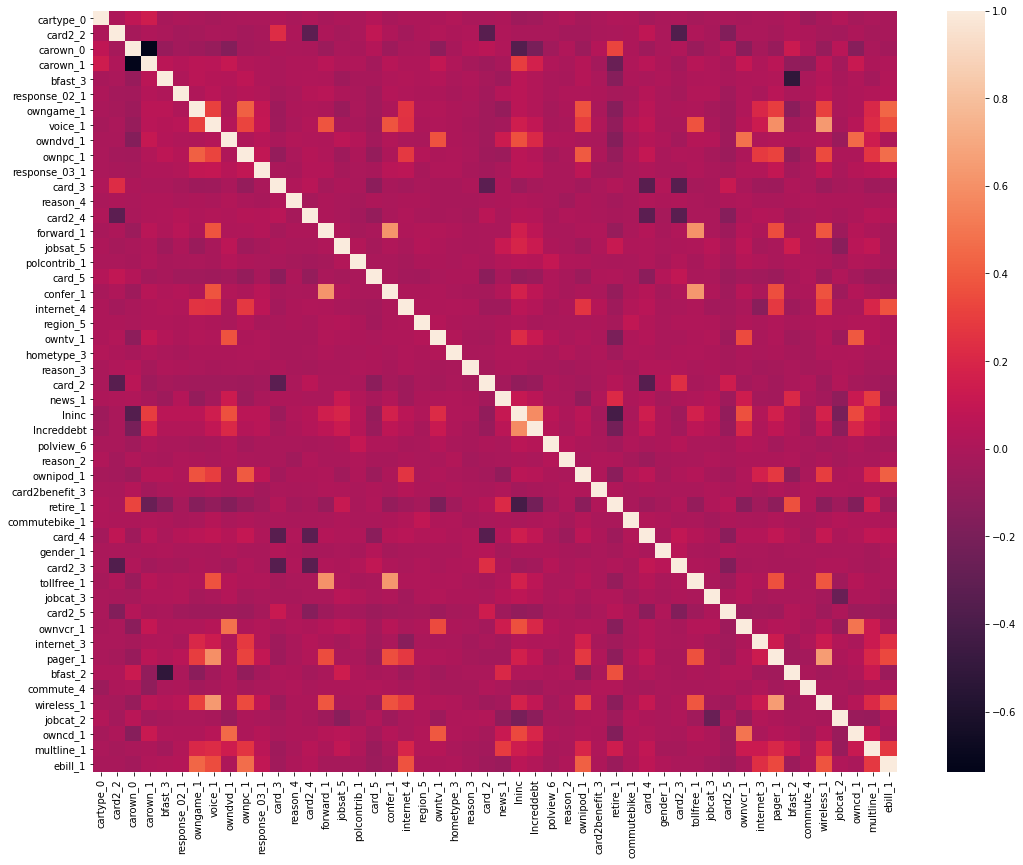

In [53]:
# Correaltion for VIF selected features
plt.figure(figsize = (18,14))
sns.heatmap(ds[vif_cols].corr())

#### <a>Getting Train and Test dataset

In [54]:
#For Statistical modelling
train, test = train_test_split(ds, test_size = 0.3, random_state = 123)

In [55]:
train.to_excel(output, 'Train Dataset', index = True)
test.to_excel(output, 'Test Dataset', index = True)

In [56]:
#Getting final model equation
'log_ts ~ '+' + '.join(vif_cols)

'log_ts ~ cartype_0 + card2_2 + carown_0 + carown_1 + bfast_3 + response_02_1 + owngame_1 + voice_1 + owndvd_1 + ownpc_1 + response_03_1 + card_3 + reason_4 + card2_4 + forward_1 + jobsat_5 + polcontrib_1 + card_5 + confer_1 + internet_4 + region_5 + owntv_1 + hometype_3 + reason_3 + card_2 + news_1 + lninc + lncreddebt + polview_6 + reason_2 + ownipod_1 + card2benefit_3 + retire_1 + commutebike_1 + card_4 + gender_1 + card2_3 + tollfree_1 + jobcat_3 + card2_5 + ownvcr_1 + internet_3 + pager_1 + bfast_2 + commute_4 + wireless_1 + jobcat_2 + owncd_1 + multline_1 + ebill_1'

In [57]:
mo_fm = '''log_ts ~ card2_5 + reason_2 + commutebike_1 + wireless_1 + internet_4 + pager_1 +
lninc + owncd_1 + polview_6 + forward_1 + bfast_3 + ownpc_1 + reason_3 + ebill_1 +
polcontrib_1 + cartype_0 + ownipod_1 + multline_1 + card_2 + bfast_2 + commute_4 + reason_4
+ response_03_1 + hometype_3 + jobcat_2 + owndvd_1 + response_02_1 + owngame_1 + card_5 +
jobcat_3 + confer_1 + ownvcr_1 + owntv_1 + tollfree_1 + region_5 + retire_1 + card2_2 +
card_4 + news_1 + card2_4 + carown_0 + card2benefit_3 + jobsat_5 + card2_3 + card_3 +
carown_1 + gender_1 + voice_1 + internet_3 + lncreddebt'''

#### <a>Linear Regression Model

In [58]:
#Building model
lm0 = smf.ols(formula = mo_fm, data = train).fit()

In [59]:
#Model Summary
print(lm0.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_ts   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     37.80
Date:                Fri, 10 Sep 2021   Prob (F-statistic):          8.52e-285
Time:                        17:43:12   Log-Likelihood:                -2727.5
No. Observations:                3500   AIC:                             5557.
Df Residuals:                    3449   BIC:                             5871.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.6580      0.108     52.

Removing insignificant variables based on p-value > 0.05 from model summary - 'commutebike_1', 'wireless_1', 'pager_1', 'owncd_1', 'polview_6', 'forward_1', 'bfast_3', 'ownpc_1', 'reason_3', 'ebill_1', 'polcontrib_1', 'cartype_0', 'ownipod_1', 'multline_1', 'bfast_2', 'commute_4', 'reason_4', 'response_03_1', 'hometype_3', 'jobcat_2', 'owndvd_1', 'response_02_1',  'owngame_1', 'jobcat_3', 'confer_1', 'ownvcr_1', 'owntv_1', 'tollfree_1', 'retire_1', 'news_1', 'carown_0', 'jobsat_5', 'carown_1', 'voice_1', 'lncreddebt'

In [60]:
#Final model formula
final_mo_fm = '''log_ts ~ card2_5 + reason_2 + internet_4 + lninc + card_2 + card_5 + region_5
+ card2_2 + card_4 + card2_4 + card2benefit_3 + card2_3 + card_3 + gender_1 + internet_3'''

In [61]:
#building model with final model formula
lm1 = smf.ols(formula = final_mo_fm, data = train).fit()

In [62]:
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_ts   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     122.2
Date:                Fri, 10 Sep 2021   Prob (F-statistic):          9.07e-306
Time:                        17:43:12   Log-Likelihood:                -2752.2
No. Observations:                3500   AIC:                             5536.
Df Residuals:                    3484   BIC:                             5635.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.5209      0.060     91.

In [63]:
#Getting tables from model summary and storing in dataframes
ms = lm1.summary()
t1 = pd.DataFrame(ms.tables[0])
t2 = pd.DataFrame(ms.tables[1])
t3 = pd.DataFrame(ms.tables[2])

#Writing model summary dataframes to excel
t1.to_excel(output, 'Model_summary', startrow=0 , startcol=0, index = False, header = False)
t2.to_excel(output, 'Model_summary', startrow=11 , startcol=0, index = False, header = False)
t3.to_excel(output, 'Model_summary', startrow=30 , startcol=0, index = False, header = False)

In [64]:
#Predicting total spent on train and test dataset
train.loc[:,'lr_pred_spent'] = np.exp(lm1.predict(train))
test.loc[:, 'lr_pred_spent'] = np.exp(lm1.predict(test))

#Getting Mean Absolute Percentage Error - MAPE
lr_MAPE_train = np.mean(np.abs(train['total_spent'] - train['lr_pred_spent'])/train['total_spent'])
lr_MAPE_test = np.mean(np.abs(test['total_spent'] - test['lr_pred_spent'])/test['total_spent'])

print('Training MAPE: ',lr_MAPE_train,' | ','Testing MAPE:' ,lr_MAPE_test)

Training MAPE:  0.48097728606673235  |  Testing MAPE: 0.44202511799995886


In [65]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.total_spent, train.lr_pred_spent)
MSE_test = metrics.mean_squared_error(test.total_spent, test.lr_pred_spent)

#Getting Root Mean Squared Error - RMSE
lr_RMSE_train = np.sqrt(MSE_train)
lr_RMSE_test = np.sqrt(MSE_test)

print('Training MSE: ',MSE_train,' | ','Testing MSE:' ,MSE_test)
print('Training RMSE: ',lr_RMSE_train,' | ','Testing RMSE:' ,lr_RMSE_test)

Training MSE:  71902.45830173709  |  Testing MSE: 70937.67397299706
Training RMSE:  268.14633747589596  |  Testing RMSE: 266.3412735063739


In [66]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.total_spent, train.lr_pred_spent)
MAE_test = metrics.mean_absolute_error(test.total_spent, test.lr_pred_spent)

print('Training MAE: ',MAE_train,' | ','Testing MAE:' ,MAE_test)

Training MAE:  188.2809030420472  |  Testing MAE: 185.89648921987995


In [67]:
#Getting Root Mean Squared Percentage Error - RMSPE
lr_RMSPE_train = np.sqrt(np.mean(((train['total_spent'] - train['lr_pred_spent'])/train['total_spent'])**2))
lr_RMSPE_test = np.sqrt(np.mean(((test['total_spent'] - test['lr_pred_spent'])/test['total_spent'])**2))

print('Training RMSPE:', lr_RMSPE_train,' | ','Testing RMSPE:', lr_RMSPE_test)

Training RMSPE: 0.7539418477181109  |  Testing RMSPE: 0.6866532566769515


In [68]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.total_spent, train.lr_pred_spent)
Corr_test = stats.stats.pearsonr(test.total_spent, test.lr_pred_spent)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.5968766134044505, 0.0) | Test Data:  (0.5643652038815531, 6.668146466284331e-127)


In [69]:
#Decile Analysis
#Creating Deciles
train.loc[:, 'Deciles'] = pd.qcut(train.lr_pred_spent, 10, labels = False)
test.loc[:, 'Deciles'] = pd.qcut(test.lr_pred_spent, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
lr_decile_train = train.groupby(['Deciles'])[['total_spent','lr_pred_spent']].mean().reset_index().sort_values(by = 'Deciles', ascending = False)
lr_decile_test = test.groupby(['Deciles'])[['total_spent','lr_pred_spent']].mean().reset_index().sort_values(by = 'Deciles', ascending = False)

In [70]:
#Deciles of train dataset
lr_decile_train.to_excel(output, 'Decile Analysis', startrow=0 , startcol=0, index = False)
lr_decile_train

,Deciles,total_spent,lr_pred_spent
9,9,921.537230,851.436731
8,8,701.442155,614.033161
7,7,587.652513,518.019059
6,6,515.521278,455.038488
5,5,460.488771,404.768757
4,4,417.032351,364.782070
3,3,380.788301,329.662359
2,2,351.255223,298.681754
1,1,311.625696,269.384097
0,0,261.005427,225.301863


In [71]:
#Deciles of test dataset
lr_decile_test.to_excel(output, 'Decile Analysis', startrow=0 , startcol=5, index = False)
lr_decile_test

,Deciles,total_spent,lr_pred_spent
9,9,864.936861,849.046161
8,8,722.254531,625.897439
7,7,582.682549,531.001991
6,6,536.721467,467.581958
5,5,475.380165,417.590021
4,4,460.913400,372.589031
3,3,385.502784,334.729866
2,2,370.495368,305.097289
1,1,324.578717,275.555880
0,0,271.900288,228.017486


#### Residual Analysis

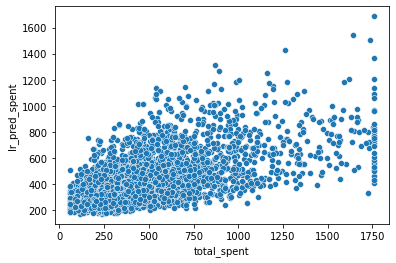

In [72]:
#True vs Predicted plot
sns.scatterplot(x = train.total_spent, y = train.lr_pred_spent)
plt.show()

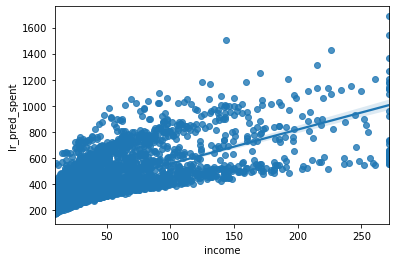

In [73]:
#Assumption: Regression model is linear
sns.regplot(x = train.income, y = train.lr_pred_spent)
plt.show()

In [74]:
#Assumption: Mean of Residuals is zero
lm1.resid.mean()

-1.0493193615600052e-15

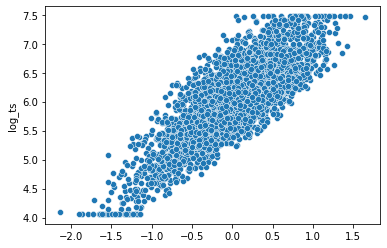

In [75]:
#Assumption: Homoscedasticity of residuals
sns.scatterplot(x = lm1.resid, y = train.log_ts)
plt.show()

In [76]:
#Assumption: The X variables and residuals are uncorrelated
print(stats.stats.pearsonr(lm1.resid, train.income))

(-0.005594411338771484, 0.7407546154098464)


In [77]:
#Assumption: The number of observations must be greater than number of Xs
train[vif_cols].shape

(3500, 50)

<AxesSubplot:ylabel='Density'>

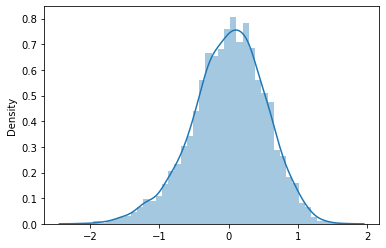

In [78]:
#Assumption: Normality of Residuals
sns.distplot(lm1.resid)

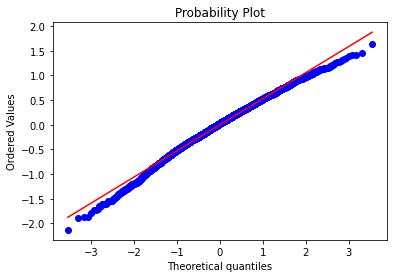

In [79]:
#Q-Q plot of Residuals
stats.probplot(lm1.resid, dist='norm', plot=pylab)
pylab.show()

The distribution plot shows normal distribution of residuals and Q-Q plot is almost linear, which shows normal distribution of the residuals. So, assumptions are not violated.

In [80]:
#Getting final features
X_cols = lm1.pvalues.index.difference(['Intercept'])
X = ds[X_cols]
Y = ds.log_ts

<BarContainer object of 15 artists>

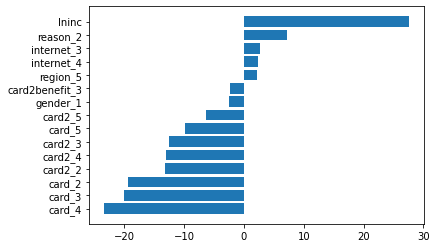

In [81]:
#Getting importance of factors
lr_fi = pd.DataFrame({'Features' : lm1.tvalues[1:].index,
                      'T_value' : lm1.tvalues[1:]
                     }).sort_values(by = 'T_value').reset_index(drop = True)

lr_fi.to_excel(output, 'Drivers', startrow=0 , startcol=0, index = False)

plt.barh(width = lr_fi.T_value, y = lr_fi.Features)

#### <a>Getting Train and Test dataset for Machine Learning modelling

In [82]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.3, random_state = 123)

#### <a>K Neighbors Model

In [83]:
#Getting parameters for best fit using GridSeachCV
pg = {'n_neighbors' : range(10,25,1)
              }

gscv_knn = GridSearchCV(estimator = KNeighborsRegressor(), 
                     param_grid = pg,
                     scoring = 'neg_mean_absolute_error',
                     cv = 14,
                     n_jobs = -1).fit(train_x, train_y)

In [84]:
#Best fit Parameters
gscv_knn.best_params_

{'n_neighbors': 24}

In [85]:
#Best Score
-1 * gscv_knn.best_score_

0.4437741272114793

In [86]:
#Using best fit parameters to fit the model
knn = gscv_knn.best_estimator_

#Predicting total spent on train and test dataset
train.loc[:, 'knn_pred_spent'] = np.exp(knn.predict(train_x))
test.loc[:, 'knn_pred_spent'] = np.exp(knn.predict(test_x))

#R-square Score
knn_r2 = metrics.r2_score(train.total_spent, train.knn_pred_spent)

print('R-square Score:', knn_r2)

#Getting Mean Absolute Percentage Error - MAPE
knn_MAPE_train = np.mean(np.abs(train['total_spent'] - train['knn_pred_spent'])/train['total_spent'])
knn_MAPE_test = np.mean(np.abs(test['total_spent'] - test['knn_pred_spent'])/test['total_spent'])
                    
print('Training MAPE:',knn_MAPE_train,' | ','Testing MAPE:',knn_MAPE_test)

R-square Score: 0.25239500029119666
Training MAPE: 0.4748372441394459  |  Testing MAPE: 0.4492736240056465


In [87]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.total_spent, train.knn_pred_spent)
MSE_test = metrics.mean_squared_error(test.total_spent, test.knn_pred_spent)

#Getting Root Mean Squared Error - RMSE
knn_RMSE_train = np.sqrt(MSE_train)
knn_RMSE_test = np.sqrt(MSE_test)

print('Training MSE: ',MSE_train,' | ','Testing MSE:' ,MSE_test)
print('Training RMSE: ',knn_RMSE_train,' | ','Testing RMSE:' ,knn_RMSE_test)

Training MSE:  79546.89194374195  |  Testing MSE: 81413.52133810005
Training RMSE:  282.040585632178  |  Testing RMSE: 285.33054750254144


In [88]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.total_spent, train.knn_pred_spent)
MAE_test = metrics.mean_absolute_error(test.total_spent, test.knn_pred_spent)

print('Training MAE: ',MAE_train,' | ','Testing MAE:' ,MAE_test)

Training MAE:  192.013537119638  |  Testing MAE: 193.76922532088093


In [89]:
#Getting Root Mean Squared Percentage Error - RMSPE
knn_RMSPE_train = np.sqrt(np.mean(((train['total_spent'] - train['knn_pred_spent'])/train['total_spent'])**2))
knn_RMSPE_test = np.sqrt(np.mean(((test['total_spent'] - test['knn_pred_spent'])/test['total_spent'])**2))

print('Training RMSPE:', knn_RMSPE_train,' | ','Testing RMSPE:', knn_RMSPE_test)

Training RMSPE: 0.7402079513106116  |  Testing RMSPE: 0.7085502955300547


In [90]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.total_spent, train.knn_pred_spent)
Corr_test = stats.stats.pearsonr(test.total_spent, test.knn_pred_spent)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.5847574256471975, 3.2183e-320) | Test Data:  (0.5119829470019893, 5.278144807660126e-101)


In [91]:
#Decile Analysis
#Creating Deciles
train.loc[:, 'knn_Deciles'] = pd.qcut(train.knn_pred_spent, 10, labels = False)
test.loc[:, 'knn_Deciles'] = pd.qcut(test.knn_pred_spent, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
knn_decile_train = train.groupby(['knn_Deciles'])[['total_spent','knn_pred_spent']].mean().reset_index().sort_values(by = 'knn_Deciles', ascending = False)
knn_decile_test = test.groupby(['knn_Deciles'])[['total_spent','knn_pred_spent']].mean().reset_index().sort_values(by = 'knn_Deciles', ascending = False)

In [92]:
knn_decile_train.to_excel(output, 'Decile Analysis', startrow=0 , startcol=9, index = False)
knn_decile_train

,knn_Deciles,total_spent,knn_pred_spent
9,9,910.456065,705.135732
8,8,695.631120,557.496638
7,7,573.279821,481.596146
6,6,531.418042,432.198655
5,5,484.653214,393.074034
4,4,405.310800,361.007465
3,3,377.725143,333.122240
2,2,350.032954,307.977898
1,1,322.037552,282.255086
0,0,257.819578,242.271605


In [93]:
knn_decile_test.to_excel(output, 'Decile Analysis', startrow=0 , startcol=13, index = False)
knn_decile_test

,knn_Deciles,total_spent,knn_pred_spent
9,9,806.038312,696.867398
8,8,705.356931,557.129530
7,7,603.256533,484.552803
6,6,510.246749,435.640266
5,5,524.123699,398.242870
4,4,445.550384,366.701226
3,3,406.624501,339.030633
2,2,356.486651,313.226464
1,1,342.891285,285.981998
0,0,294.791085,243.768172


#### <a>Random Forest Model

In [94]:
#Getting parameters for best fit using GridSeachCV
pg = {  'max_depth' : range(11,16,1),
        'min_samples_split' : [2,3,4],
        'min_samples_leaf' : range(13,18,1)
              }

gscv_rf = GridSearchCV(estimator = RandomForestRegressor(random_state = 123), 
                     param_grid = pg,
                     scoring = 'neg_mean_squared_error',
                     cv = 5,
                     n_jobs = -1).fit(train_x, train_y)

In [95]:
#Best fit Parameters
gscv_rf.best_params_

{'max_depth': 13, 'min_samples_leaf': 16, 'min_samples_split': 2}

In [96]:
#Best Score
-1*gscv_rf.best_score_

0.29998936166100837

In [97]:
#Using best fit parameters to fit the model
rf = gscv_rf.best_estimator_

#Predicting total spent on train and test dataset
train.loc[:, 'rf_pred_spent'] = np.exp(rf.predict(train_x))
test.loc[:, 'rf_pred_spent'] = np.exp(rf.predict(test_x))

#R-square Score
rf_r2 = metrics.r2_score(train.total_spent, train.rf_pred_spent)

print('R-square Score:', rf_r2)

#Getting Mean Absolute Percentage Error - MAPE
rf_MAPE_train = np.mean(np.abs(train['total_spent'] - train['rf_pred_spent'])/train['total_spent'])
rf_MAPE_test = np.mean(np.abs(test['total_spent'] - test['rf_pred_spent'])/test['total_spent'])
                    
print('Training MAPE: ',rf_MAPE_train,' | ','Testing MAPE:',rf_MAPE_test)

R-square Score: 0.36058574853265835
Training MAPE:  0.4571622734238494  |  Testing MAPE: 0.4730632086695054


In [98]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.total_spent, train.rf_pred_spent)
MSE_test = metrics.mean_squared_error(test.total_spent, test.rf_pred_spent)

#Getting Root Mean Squared Error - RMSE
rf_RMSE_train = np.sqrt(MSE_train)
rf_RMSE_test = np.sqrt(MSE_test)

print('Training MSE: ',MSE_train,' | ','Testing MSE:' ,MSE_test)
print('Training RMSE: ',rf_RMSE_train,' | ','Testing RMSE:',rf_RMSE_test)

Training MSE:  68035.14742219872  |  Testing MSE: 78241.49621170775
Training RMSE:  260.835479607738  |  Testing RMSE: 279.71681431710135


In [99]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.total_spent, train.rf_pred_spent)
MAE_test = metrics.mean_absolute_error(test.total_spent, test.rf_pred_spent)

print('Training MAE: ',MAE_train,' | ','Testing MAE:' ,MAE_test)

Training MAE:  180.40004623417497  |  Testing MAE: 194.18764428540956


In [100]:
#Getting Root Mean Squared Percentage Error - RMSPE
rf_RMSPE_train = np.sqrt(np.mean(((train['total_spent'] - train['rf_pred_spent'])/train['total_spent'])**2))
rf_RMSPE_test = np.sqrt(np.mean(((test['total_spent'] - test['rf_pred_spent'])/test['total_spent'])**2))

print('Training RMSPE:', rf_RMSPE_train,' | ','Testing RMSPE:', rf_RMSPE_test)

Training RMSPE: 0.7119761244177696  |  Testing RMSPE: 0.7573121743862581


In [101]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.total_spent, train.rf_pred_spent)
Corr_test = stats.stats.pearsonr(test.total_spent, test.rf_pred_spent)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.641251225614303, 0.0) | Test Data:  (0.502004191290097, 1.4496944311182796e-96)


In [102]:
#Decile Analysis
#Creating Deciles
train.loc[:, 'rf_Deciles'] = pd.qcut(train.rf_pred_spent, 10, labels = False)
test.loc[:, 'rf_Deciles'] = pd.qcut(test.rf_pred_spent, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
rf_decile_train = train.groupby(['rf_Deciles'])[['total_spent','rf_pred_spent']].mean().reset_index().sort_values(by = 'rf_Deciles', ascending = False)
rf_decile_test = test.groupby(['rf_Deciles'])[['total_spent','rf_pred_spent']].mean().reset_index().sort_values(by = 'rf_Deciles', ascending = False)

In [103]:
rf_decile_train.to_excel(output, 'Decile Analysis', startrow=0 , startcol=17, index = False)
rf_decile_train

,rf_Deciles,total_spent,rf_pred_spent
9,9,944.809101,816.076116
8,8,724.170841,603.339338
7,7,593.066163,500.735499
6,6,519.309174,445.473306
5,5,456.749928,402.211481
4,4,416.699679,366.687731
3,3,359.001993,336.921726
2,2,342.272322,308.925332
1,1,308.129702,283.174390
0,0,244.352894,226.273057


In [104]:
rf_decile_test.to_excel(output, 'Decile Analysis', startrow=0 , startcol=21, index = False)
rf_decile_test

,rf_Deciles,total_spent,rf_pred_spent
9,9,838.394960,817.068131
8,8,662.954549,603.185765
7,7,577.728416,512.583266
6,6,516.462699,456.477492
5,5,523.278467,409.984846
4,4,457.686360,372.150621
3,3,414.483592,344.193936
2,2,362.518203,318.188262
1,1,331.515136,287.168254
0,0,310.631768,230.866478


<BarContainer object of 15 artists>

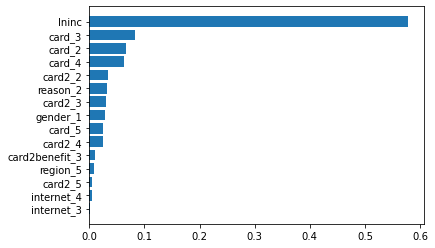

In [105]:
#Feature Impotance for Random Forest Model
rf_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : gscv_rf.best_estimator_.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

rf_fi.to_excel(output, 'Drivers', startrow=17, startcol=0, index = False)

plt.barh(width = rf_fi.Importance, y = rf_fi.Features)

#### <a>Gradient Boost Model

In [106]:
#Getting parameters for best fit using GridSeachCV
pg = {  'max_depth' : range(1,6,1),
        'min_samples_split' : [2,3,4],
        'min_samples_leaf' : range(12,17,1)
     }

gscv_gb = GridSearchCV(estimator = GradientBoostingRegressor(random_state = 123), 
                     param_grid = pg,
                     cv = 5,
                     n_jobs = -1).fit(train_x, train_y)


In [107]:
#Best fit Parameters
gscv_gb.best_params_

{'max_depth': 3, 'min_samples_leaf': 14, 'min_samples_split': 2}

In [108]:
#Best Score
gscv_gb.best_score_

0.3227264140008036

In [109]:
#Using best fit parameters to fit the model
gb = gscv_gb.best_estimator_

#Predicting total spent on train and test dataset
train.loc[:, 'gb_pred_spent'] = np.exp(gb.predict(train_x))
test.loc[:, 'gb_pred_spent'] = np.exp(gb.predict(test_x))

#R-square Score
gb_r2 = metrics.r2_score(train.total_spent, train.gb_pred_spent)

print('R-square Score:', gb_r2)

#Getting Mean Absolute Percentage Error - MAPE
gb_MAPE_train = np.mean(np.abs(train['total_spent'] - train['gb_pred_spent'])/train['total_spent'])
gb_MAPE_test = np.mean(np.abs(test['total_spent'] - test['gb_pred_spent'])/test['total_spent'])
                    
print('Training MAPE: ',gb_MAPE_train,' | ','Testing MAPE:' ,gb_MAPE_test)

R-square Score: 0.3374157562635969
Training MAPE:  0.46670648470619097  |  Testing MAPE: 0.455798814398106


In [110]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.total_spent, train.gb_pred_spent)
MSE_test = metrics.mean_squared_error(test.total_spent, test.gb_pred_spent)

#Getting Root Mean Squared Error - RMSE
gb_RMSE_train = np.sqrt(MSE_train)
gb_RMSE_test = np.sqrt(MSE_test)

print('Training MSE: ',MSE_train,' | ','Testing MSE:' ,MSE_test)
print('Training RMSE: ',gb_RMSE_train,' | ','Testing RMSE:' ,gb_RMSE_test)

Training MSE:  70500.48790558535  |  Testing MSE: 74655.04894659648
Training RMSE:  265.5192797248165  |  Testing RMSE: 273.2307613476134


In [111]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.total_spent, train.gb_pred_spent)
MAE_test = metrics.mean_absolute_error(test.total_spent, test.gb_pred_spent)

print('Training MAE: ',MAE_train,' | ','Testing MAE:' ,MAE_test)

Training MAE:  183.64323357693658  |  Testing MAE: 189.52046602691772


In [112]:
#Getting Root Mean Squared Percentage Error - RMSPE
gb_RMSPE_train = np.sqrt(np.mean(((train['total_spent'] - train['gb_pred_spent'])/train['total_spent'])**2))
gb_RMSPE_test = np.sqrt(np.mean(((test['total_spent'] - test['gb_pred_spent'])/test['total_spent'])**2))

print('Training RMSPE:', gb_RMSPE_train,' | ','Testing RMSPE:', gb_RMSPE_test)

Training RMSPE: 0.7354922832434039  |  Testing RMSPE: 0.7220427686670843


In [113]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.total_spent, train.gb_pred_spent)
Corr_test = stats.stats.pearsonr(test.total_spent, test.gb_pred_spent)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.6187968266247703, 0.0) | Test Data:  (0.5370554990069092, 7.852749330216568e-113)


In [114]:
#Decile Analysis
#Creating Deciles
train.loc[:, 'gb_Deciles'] = pd.qcut(train.gb_pred_spent, 10, labels = False)
test.loc[:, 'gb_Deciles'] = pd.qcut(test.gb_pred_spent, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
gb_decile_train = train.groupby(['gb_Deciles'])[['total_spent','gb_pred_spent']].mean().reset_index().sort_values(by = 'gb_Deciles', ascending = False)
gb_decile_test = test.groupby(['gb_Deciles'])[['total_spent','gb_pred_spent']].mean().reset_index().sort_values(by = 'gb_Deciles', ascending = False)

In [115]:
gb_decile_train.to_excel(output, 'Decile Analysis', startrow=0 , startcol=25, index = False)
gb_decile_train

,gb_Deciles,total_spent,gb_pred_spent
9,9,950.186894,822.819615
8,8,691.937828,580.760514
7,7,581.269230,496.851265
6,6,519.531926,441.052086
5,5,469.584943,406.635823
4,4,413.075664,369.377710
3,3,375.400295,338.621887
2,2,341.829438,314.559812
1,1,313.231662,288.436159
0,0,253.439395,227.691186


In [116]:
gb_decile_test.to_excel(output, 'Decile Analysis', startrow=0 , startcol=29, index = False)
gb_decile_test

,gb_Deciles,total_spent,gb_pred_spent
9,9,855.554160,820.578836
8,8,669.849083,587.266455
7,7,626.874059,502.412503
6,6,519.300464,448.401228
5,5,496.621749,415.784561
4,4,438.379317,376.210050
3,3,427.036933,344.678477
2,2,339.003117,320.911615
1,1,336.025269,294.432851
0,0,287.439136,232.321964


<BarContainer object of 15 artists>

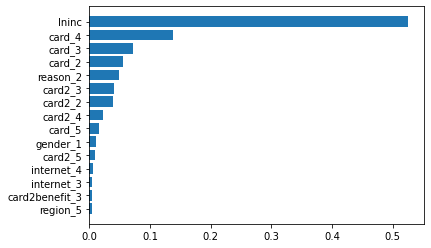

In [117]:
#Feature Impotance for Gradient Boost Model
gb_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : gscv_gb.best_estimator_.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)
gb_fi.to_excel(output, 'Drivers', startrow=34, startcol=0, index = False)

plt.barh(width = gb_fi.Importance, y = gb_fi.Features)

#### <a>Evaluating the different metrics for each model

In [118]:
#Getting accuracy and log loss for each model
model_data = pd.DataFrame({'Regressor' : ['LinearRegressor', 'KNeighborsRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor'],
                        'R2 Score' : [lm1.rsquared, knn_r2, rf_r2, gb_r2],
                        'MAPE_train' : [lr_MAPE_train, knn_MAPE_train, rf_MAPE_train, gb_MAPE_train],
                        'MAPE_test' : [lr_MAPE_test, knn_MAPE_test, rf_MAPE_test, gb_MAPE_test],
                        'RMSE_train' : [lr_RMSE_train, knn_RMSE_train, rf_RMSE_train, gb_RMSE_train],
                        'RMSE_test' : [lr_RMSE_test, knn_RMSE_test, rf_RMSE_test, gb_RMSE_test],
                        'RMSPE_train' : [lr_RMSPE_train, knn_RMSPE_train, rf_RMSPE_train, gb_RMSPE_train],  
                        'RMSPE_test' : [lr_RMSPE_test, knn_RMSPE_test, rf_RMSPE_test, gb_RMSPE_test]
                        })

In [119]:
model_data.to_excel(output, 'Metrics of Models', index = False)
model_data

,Regressor,R2 Score,MAPE_train,MAPE_test,RMSE_train,RMSE_test,RMSPE_train,RMSPE_test
0,LinearRegressor,0.344769,0.480977,0.442025,268.146337,266.341274,0.753942,0.686653
1,KNeighborsRegressor,0.252395,0.474837,0.449274,282.040586,285.330548,0.740208,0.708550
2,RandomForestRegressor,0.360586,0.457162,0.473063,260.835480,279.716814,0.711976,0.757312
3,GradientBoostingRegressor,0.337416,0.466706,0.455799,265.519280,273.230761,0.735492,0.722043


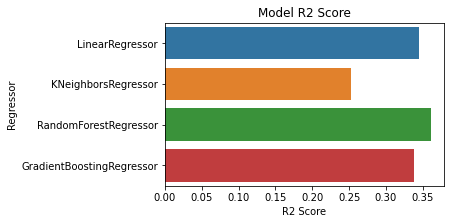

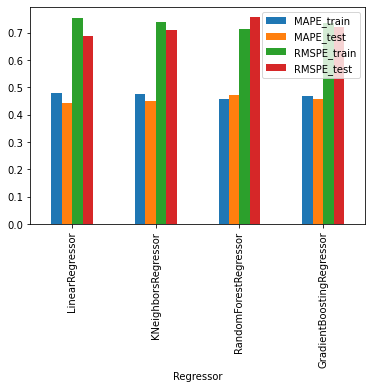

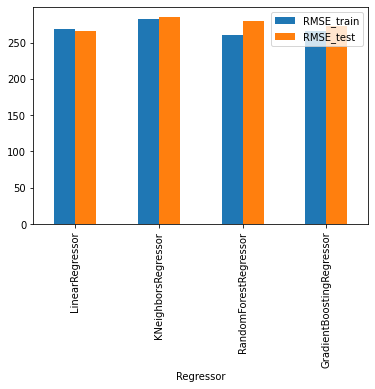

In [120]:
#Visualizing different metrics of the models
plt.figure(figsize = (5,3))
sns.barplot(data = model_data, x = model_data['R2 Score'], y = model_data.Regressor)
plt.title('Model R2 Score')

model_data.plot(x = 'Regressor', y = ['MAPE_train', 'MAPE_test', 'RMSPE_train', 'RMSPE_test'], kind = 'bar')
model_data.plot(x = 'Regressor', y = ['RMSE_train', 'RMSE_test'], kind = 'bar')
plt.show()

In [121]:
#Creating a DataFrame to store final prediction and Credit Limit
pre_df = pd.DataFrame()

#Getting Key Drivers for prediction
ds_new = ds[X_cols]

#Making Final Prediction using Gradient Boost Model
pre_df['Predicted_Spend'] = np.exp(gb.predict(ds_new))

#Configuration Parameters
p1 = 0.5
p2 = 0.7
p3 = 1
p4 = 1.5

#Defining Credit Limit
pre_df['Credit_Limit'] = np.where(ds['incdebtratio_cat']<=3, pre_df['Predicted_Spend']*p1,
                         np.where(ds['incdebtratio_cat']==4, pre_df['Predicted_Spend']*p2,
                         np.where(ds['incdebtratio_cat']==5, pre_df['Predicted_Spend']*p3,
                                                             pre_df['Predicted_Spend']*p4)))

#Combining final data
final_ds = pd.concat([ds_new, ds['total_spent'], pre_df], axis = 1)

#Final data view
final_ds[['Predicted_Spend', 'Credit_Limit']].head()

,Predicted_Spend,Credit_Limit
0,350.342187,175.171093
1,229.759975,114.879988
2,439.359164,219.679582
3,311.851399,155.925699
4,384.927475,192.463738


In [122]:
#Saving to excel
final_ds.to_excel(output, 'Predicted Total Spend', index = False)

In [123]:
output.save()